<a href="https://colab.research.google.com/github/DMartinezT/msc_oxford_dissertation/blob/main/def_matched_UCMAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
! pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.metrics import pairwise_distances

import torch
import torch.nn as nn
from torch.optim import Adam

import gpytorch
from gpytorch.kernels import Kernel
from gpytorch.kernels import RBFKernel
from gpytorch.constraints import Positive

from mpl_toolkits.mplot3d import Axes3D

from google.colab import files
from tqdm import trange
import math
from IPython import display
from time import sleep




In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [ ]:
verbose_int = 5

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(0)

In [ ]:
rounds = 100
f_bound = 10
cme_bound = 10
original = False
m = 0
learn_freq = 5

# Kernel

In [ ]:
def median_heuristic(x):
    x_np = x.numpy()

    return np.median(pairwise_distances(x_np))

def postprocess_rbf(dist_mat):
    return dist_mat.div_(-2).exp_()

In [ ]:
class RBFKernel_with_ND(Kernel):

    def __init__(self, eta=torch.tensor(1.), **kwargs):
        super(RBFKernel_with_ND, self).__init__(**kwargs)

        self.register_parameter(
            name="raw_eta", parameter=torch.nn.Parameter(eta)
        )
        eta_constraint = Positive()

        self.register_constraint("raw_eta", eta_constraint)

    has_lengthscale = True

    @property
    def eta(self):
        return self.raw_eta_constraint.transform(self.raw_eta)
    
    @eta.setter
    def eta(self, value):
        return self._set_eta(value)
    
    def _set_eta(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_eta)
        
        self.initialize(raw_eta=self.raw_eta_constraint.inverse_transform(value))
    

    def forward(self, x1, x2, nuc_dom=False, diag=False, **params):

        if nuc_dom:
            
            # 2 times the lengthscale to obtain the first exp component
            x1_ = x1.div(np.sqrt(2)*self.lengthscale)
            x2_ = x2.div(np.sqrt(2)*self.lengthscale)

            first_component = self.covar_dist(x1_, x2_, square_dist=True, diag=diag, dist_postprocess_func=postprocess_rbf, postprocess=True, **params)

            # computing the non-stationary component
            x1_p = x1.div(2)
            x2_p = x2.div(2)
            x1_2 = x1_p.div(torch.sqrt(0.5*self.lengthscale**2 + self.eta**2))
            x2_2 = -x2_p.div(torch.sqrt(0.5*self.lengthscale**2 + self.eta**2))

            second_component = self.covar_dist(x1_2, x2_2, square_dist=True, diag=diag, dist_postprocess_func=postprocess_rbf, postprocess=True, **params)

            # scaling factor
            D = len(self.lengthscale)
            scale = (2*np.pi)**(D/2)*torch.prod(2 / self.lengthscale + self.eta**(-2))**(-0.5)

            #return scale * first_component*second_component            
            return scale*first_component*second_component            

            
        else:
            x1_ = x1.div(self.lengthscale)
            x2_ = x2.div(self.lengthscale)
            return self.covar_dist(
                x1_, x2_, square_dist=True, diag=diag, dist_postprocess_func=postprocess_rbf, postprocess=True, **params
            )

In [ ]:
def nll(K_lambda, R_lambda, L):
    N = K_lambda.shape[0]
    LRinvL = L.evaluate() @ R_lambda.inv_matmul(L.evaluate())

    return N*(K_lambda.logdet() + R_lambda.logdet()) + torch.trace(K_lambda.inv_matmul(LRinvL))

class NDBayesCME_learner(nn.Module):

    def __init__(self, x, y, lambda_init, eta_init):
        super().__init__()

        # Setup
        self.x, self.y = x, y
        self.k_x = RBFKernel(ard_num_dims=x.shape[1])
        self.lmda = torch.nn.Parameter(lambda_init)
        self.eta = torch.nn.Parameter(eta_init)

        self.l_y = RBFKernel_with_ND(ard_num_dims=y.shape[1], eta=self.eta)

        # Initialise kernel with median heuristic hyperparameters
        self.k_x.lengthscale = torch.Tensor([median_heuristic(x)])
        self.l_y.lengthscale = torch.Tensor([median_heuristic(y)])

    def forward(self, nuc_reg=1e-4):

        K = self.k_x(self.x)
        L = self.l_y(self.y)
        R = self.l_y(self.y, nuc_dom=True)

        nuc_reg = torch.tensor(nuc_reg)
        K_lambda = K.add_diag(self.lmda**2 + nuc_reg) # ensure positivity
        R_lambda = R.add_diag(nuc_reg) # Ensure invertability
        
        return K_lambda, R_lambda, L

def learn_parameters(x, y, lambda_init, eta_init, epoch, lr, fixed_y_lscale, fixed_eta, fixed_x_scle = None, fixed_lambda = None, nuc_reg = 1e-4, verbose = True):

    NDBayes_CME = NDBayesCME_learner(x=x, y=y, lambda_init=lambda_init, eta_init=eta_init)

    if fixed_x_scle is not None:
        NDBayes_CME.k_x.raw_lengthscale.requires_grad = False
        NDBayes_CME.k_x.lengthscale = fixed_x_scle

    if fixed_y_lscale is not None:
        NDBayes_CME.l_y.raw_lengthscale.requires_grad = False
        NDBayes_CME.l_y.lengthscale = fixed_y_lscale
        
    if fixed_eta is not None:
        NDBayes_CME.l_y.raw_eta.requires_grad = False
        NDBayes_CME.l_y.eta = fixed_eta
    
    if fixed_lambda is not None:
        NDBayes_CME.lmda.requires_grad = False

    optim = Adam(NDBayes_CME.parameters(), lr=lr)

    for _ in range(epoch):

        K_lambda, R_lambda, L = NDBayes_CME(nuc_reg = nuc_reg)
        loss = nll(K_lambda, R_lambda, L)

        if _ % verbose_int == 0:
          if verbose:
            print("Loss at round %i: %f"%(_, loss) )
        
        loss.backward()
        optim.step()
        optim.zero_grad()

    optim_x_lengthscale = NDBayes_CME.k_x.lengthscale
    optim_y_lengthscale = NDBayes_CME.l_y.lengthscale
    optim_eta = NDBayes_CME.l_y.eta
    optim_lambda = NDBayes_CME.lmda

    return optim_x_lengthscale.detach(), optim_y_lengthscale.detach(), optim_eta.detach(), optim_lambda.detach()



# GP

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood, y_lscale = None, eta = torch.tensor(3.)):
      super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
      self.mean_module = gpytorch.means.ConstantMean()
      self.covar_module = RBFKernel_with_ND(ard_num_dims=train_x.shape[1], eta=eta)
      # We need to change "Eta requires grad" if we do not want to learn it!!!
      if y_lscale is not None:
        self.covar_module.lengthscale = y_lscale
        self.covar_module.raw_lengthscale.requires_grad = False

  def forward(self, x, nuc_dom = True):
      mean_x = self.mean_module(x)
      covar_x = self.covar_module(x, nuc_dom=nuc_dom)
      return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_GP(y2ten, tten, lr, epoch, fixed_y_lscale = None, fixed_eta = None, verbose = True):


  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  model = ExactGPModel(y2ten, tten, likelihood)

  if fixed_y_lscale is not None:
    model.covar_module.raw_lengthscale.requires_grad = False
    model.covar_module.lengthscale = fixed_y_lscale
  
  if fixed_eta is not None:
    model.covar_module.raw_eta.requires_grad = False
    model.covar_module.eta = fixed_eta

  model.train()
  likelihood.train()

  optim = torch.optim.Adam(model.parameters(), lr=lr)
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  for i in range(epoch):
      optim.zero_grad()
      output = model(y2ten)
      loss = -mll(output, tten)
      loss.backward()

      if i % verbose_int == 0:
          if verbose:
              print('GP training! Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f  eta: %.3f' % (
                  i + 1, epoch, loss.item(),
                  model.covar_module.lengthscale.item(),
                  model.likelihood.noise.item(), 
                  model.covar_module.eta.item(),
              ))
      
      optim.step()

  # Collect the hyperparam results:
  optim_noise = model.likelihood.noise.detach()
  optim_eta = model.covar_module.eta.detach()
  optim_y_scle = model.covar_module.lengthscale.detach()

  return optim_eta, optim_y_scle, optim_noise, model, likelihood

# CBMP-UCB

In [ ]:
class CBMPUCB(object):

  def __init__(self, actions, contexts, sample_from_environment, gen_f, y2ten, tten, params, inner_model, inner_likelihood, r_dim, delta=0.80):
    # create action-context pairs via a meshgrid.
    self.input_mesh = np.array(np.meshgrid(actions, contexts))
    # number of actions in each context. currently only supports equal number of actions for each context.
    # We could have also done actions.size
    self.number_of_actions_in_each_context = np.size(self.input_mesh, 2)

    self.sample_from_environment = sample_from_environment
    self.beta = None
    self.delta = delta

    self.input_space = self.input_mesh.reshape(self.input_mesh.shape[0], -1).T
    self.input_space_size = self.input_space.size

    self.mu = np.array([0. for _ in range(self.input_space.shape[0])])
    self.sigma = np.array([.5 for _ in range(self.input_space.shape[0])])

    self.gen_f = gen_f
    self.y2ten = y2ten.clone()
    self.tten = tten.clone()

    self.optim_x_scle = params['optim_x_scle']
    self.optim_y_scle = params['optim_y_scle']
    self.optim_eta = params['optim_eta']
    self.optim_noise = params['optim_noise'].clone().detach()
    self.optim_lambda = torch.tensor(params['optim_lambda'])

    self.inner_model = inner_model
    self.inner_likelihood = inner_likelihood
    
    self.X = []
    self.Y = []
    self.round = 1

    self.r_dim = r_dim
    return

  def cgp_ucb_rule(self, context_index):

    # deduce the indices of the actions for the given context.
    context = int(context_index)
    lower_bound_on_actions = context*self.number_of_actions_in_each_context
    upper_bound_on_actions = (context+1)*self.number_of_actions_in_each_context

    # point selection rule
    return lower_bound_on_actions + np.argmax(
      self.mu[lower_bound_on_actions:upper_bound_on_actions] +
      self.sigma[lower_bound_on_actions:upper_bound_on_actions] * np.sqrt(self.beta))
    

  # CBMP-UCB
  def return_mean_and_covariance(self, nuc_reg=1e-4, krr_reg=None, cme_reg=None):
    # Unload data
    X = self.X
    y = self.Y
    Xten = torch.tensor(X).float()
    y1ten = torch.squeeze(torch.tensor(y), 1).float()
    y2ten = self.y2ten
    tten = self.tten
    test_x = torch.tensor(self.input_space).float()

    # Define kernels using the optimal params
    k = RBFKernel_with_ND(ard_num_dims=Xten.shape[1])
    k.lengthscale = self.optim_x_scle
    l = RBFKernel_with_ND(ard_num_dims=y2ten.shape[1])
    l.lengthscale = self.optim_y_scle
    l.eta = self.optim_eta

    if krr_reg == None:
        krr_reg = self.optim_noise.clone().detach()
    if cme_reg == None:
        cme_reg = self.optim_lambda.clone().detach()**2
    nuc_reg = torch.tensor(nuc_reg)

    # Posterior Mean for case 3
    y3ten = torch.cat([y1ten, y2ten])

    ELy1y3 = k(test_x, Xten) @ k(Xten).add_diag(cme_reg).inv_matmul(l(y1ten, y3ten).evaluate())
    Ly3y3_invR = l(y3ten).add_diag(nuc_reg).inv_matmul(l(y3ten, y2ten, nuc_dom=True).evaluate())
    Ry2y2_invt = l(y2ten, nuc_dom=True).add_diag(krr_reg).inv_matmul(tten.float())
    posterior_mean = ELy1y3 @ Ly3y3_invR @ Ry2y2_invt

    # left sum
    R_y3y3 = l(y3ten, nuc_dom=True)
    R_y2y2 = l(y2ten, nuc_dom=True)
    R_y3y2 = l(y3ten, y2ten, nuc_dom=True)
    R_y3y1 = l(y3ten, y1ten, nuc_dom=True)
    R_y1y1 = l(y1ten, nuc_dom=True)

    R_bar = R_y3y3.evaluate() - R_y3y2.evaluate() @ R_y2y2.add_diag(krr_reg).inv_matmul(R_y3y2.evaluate().T)
    L_y3y1 = l(y3ten, y1ten)
    L_y3y3 = l(y3ten)
    L_y2y2 = l(y2ten)
    L_y1y1 = l(y1ten)
    
    # We took off the nuc_reg but we might want to add it again
    # right_part = L_y3y3.add_diag(nuc_reg).inv_matmul(L_y3y1.evaluate())@k(Xten).add_diag(cme_reg).inv_matmul(k(Xten, test_x).evaluate())
    theta1 =  L_y3y3.add_diag(nuc_reg).inv_matmul(R_y3y1.evaluate()) @ R_y1y1.add_diag(nuc_reg).inv_matmul(L_y1y1.evaluate())
    Et = k(Xten).add_diag(cme_reg).inv_matmul(k(Xten, test_x).evaluate())
    right_part = theta1 @ Et
    left_part = right_part.T
    gp_cov1 = left_part @ R_bar @ right_part

    # Right sum
    # Again we get rid of the nuc_reg, we could add it at some point
    Theta4 = L_y3y3.add_diag(nuc_reg).inv_matmul((R_y3y2.evaluate() @ L_y2y2.add_diag(krr_reg).inv_matmul(tten.reshape(-1, 1))))
    # Theta4 = L_y3y3.inv_matmul((R_y3y2.evaluate() @ L_y2y2.add_diag(krr_reg).inv_matmul(tten.reshape(-1, 1))))
    Theta2 = Theta4.T @ R_y3y3.evaluate() @ Theta4
    # Again we get rid of the nuc_reg, we could add it at some point
    Theta3 = Theta4.T @ R_y3y1.evaluate() @ R_y1y1.add_diag(nuc_reg).inv_matmul(R_y3y1.evaluate().T) @ Theta4
    # Theta3 = Theta4.T @ R_y3y1.evaluate() @ R_y1y1.inv_matmul(R_y3y1.evaluate().T) @ Theta4

    F = k(test_x).evaluate()
    G = k(test_x, Xten).evaluate()@k(Xten).add_diag(cme_reg).inv_matmul(k(Xten, test_x).evaluate())
    gp_cov2 = Theta2*F - Theta3*G
    # Trace term
    term1 = L_y3y3.add_diag(nuc_reg).inv_matmul(R_y3y3.evaluate()) @ L_y3y3.add_diag(nuc_reg).inv_matmul(R_bar)
    # term1 = L_y3y3.inv_matmul(R_y3y3.evaluate()) @ L_y3y3.inv_matmul(R_bar)
    term2 = L_y3y3.add_diag(nuc_reg).inv_matmul(R_y3y1.evaluate()) @ R_y1y1.add_diag(nuc_reg).inv_matmul(R_y3y1.evaluate().T) @ L_y3y3.add_diag(nuc_reg).inv_matmul(R_bar)
    # term2 = L_y3y3.inv_matmul(R_y3y1.evaluate()) @ R_y1y1.inv_matmul(R_y3y1.evaluate().T) @ L_y3y3.inv_matmul(R_bar)
    trace1 = torch.trace(term1)
    trace2 = torch.trace(term2)
    gp_cov3 = F * trace1 - G * trace2
    gp_diag1 = np.diag(gp_cov1.detach().numpy())
    gp_diag2 = np.diag(gp_cov2.detach().numpy())
    gp_diag3 = np.diag(gp_cov3.detach().numpy())
    posterior_std = np.sqrt(gp_diag1 + gp_diag2 + gp_diag3).reshape(-1)

    return posterior_mean.detach().numpy(), posterior_std

  def learn(self, context_index, nuc_reg = 1e-4, learn_freq = 50):
    # choose optimal beta.
    self.beta = self.optimal_beta_selection(self.round, self.input_space_size, self.delta)

    # choose new sampling point using cgp-ucb for the given context.
    grid_idx = self.cgp_ucb_rule(context_index)
    self.sample(self.input_space[grid_idx])

    # get mu and sigma predictions.
    self.mu, self.sigma = self.return_mean_and_covariance(nuc_reg=1e-4)

    # increment round #.
    self.round += 1

    epoch = 100
    lr = 1e-1
    if self.round % learn_freq == 0 and self.round > 2:

      # Initialise kernel with median heuristic hyperparameters
      X = torch.tensor(self.X).float()
      Y = torch.tensor(self.Y).float().squeeze(1)
      optim_lambda = self.optim_lambda.clone().detach().float()

      self.optim_x_scle = torch.Tensor([median_heuristic(X)])
      self.optim_y_scle = torch.Tensor([median_heuristic(Y)])
      self.optim_eta = 1 
      
      self.optim_eta, self.optim_y_scle, self.optim_noise, self.inner_model, self.inner_likelihood = train_GP(
          self.y2ten, self.tten, lr, epoch, fixed_y_lscale = self.optim_y_scle, fixed_eta = self.optim_eta, verbose = False)
      self.inner_model.eval()
      self.inner_likelihood.eval()
      self.optim_x_scle, self.optim_y_scle, self.optim_eta, self.optim_lambda = learn_parameters(
          X, Y, optim_lambda, self.optim_eta, epoch, lr, self.optim_y_scle, self.optim_eta,  self.optim_x_scle, None, nuc_reg = nuc_reg, verbose = False)
    return

  def sample(self, x):
    y = self.sample_from_environment(x)
    t = self.gen_f(np.array(y))
    self.X.append(x)
    self.Y.append(y)

    self.y2ten = torch.cat((self.y2ten, torch.tensor(y).float().reshape(1,self.r_dim) ))
    self.tten = torch.cat((self.tten, torch.tensor(t).float().reshape(-1) ))
    return

  def optimal_beta_selection(self, t, input_space_size, delta):
    return 2 * np.log(input_space_size * (t ** 2) * (np.pi ** 2) / (6 * delta))

  def plot_environment_and_mean(self):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title('Environment, Mean and Data on a 3d Plot')
    ax.set_xlabel('Action')
    ax.set_ylabel('Context')
    ax.set_zlabel('Reward')

    # plot self.mu on a wire frame.
    ax.plot_wireframe(self.input_mesh[0], self.input_mesh[1],
                      self.mu.reshape(self.input_mesh[0].shape), alpha=0.6, color='g', label='mean')
    # now plot sample environment at all values of the input space and plot.
    ax.plot_wireframe(self.input_mesh[0], self.input_mesh[1],
                      np.array(self.gen_f(np.array(self.sample_from_environment(self.input_mesh)))).reshape(self.input_mesh[0].shape),
                      alpha=0.5, color='b', label='environment')
    # scatter plot data on top.
    ax.scatter([x[0] for x in self.X], [x[1] for x in self.X], self.T, c='r',
               marker='o', alpha=1.0, label='data')
    ax.legend()
    return

# CBME-UCB

In [ ]:
class CBMEUCB(object):

  def __init__(self, actions, contexts, sample_from_environment, gen_f, y2ten, tten, params, inner_model, inner_likelihood, r_dim, delta=0.80):
    # create action-context pairs via a meshgrid.
    self.input_mesh = np.array(np.meshgrid(actions, contexts))
    # number of actions in each context. currently only supports equal number of actions for each context.
    # We could have also done actions.size
    self.number_of_actions_in_each_context = np.size(self.input_mesh, 2)

    self.sample_from_environment = sample_from_environment
    self.beta = None
    self.delta = delta

    self.input_space = self.input_mesh.reshape(self.input_mesh.shape[0], -1).T
    self.input_space_size = self.input_space.size

    self.mu = np.array([0. for _ in range(self.input_space.shape[0])])
    self.sigma = np.array([.5 for _ in range(self.input_space.shape[0])])

    self.gen_f = gen_f
    self.y2ten = y2ten.clone()
    self.tten = tten.clone()

    self.optim_x_scle = params['optim_x_scle']
    self.optim_y_scle = params['optim_y_scle']
    self.optim_eta = params['optim_eta']
    self.optim_noise = params['optim_noise'].clone().detach()
    self.optim_lambda = torch.tensor(params['optim_lambda'])

    self.inner_model = inner_model
    self.inner_likelihood = inner_likelihood
    
    self.X = []
    self.Y = []
    self.round = 1

    self.r_dim = r_dim
    return

  def cgp_ucb_rule(self, context_index):

    # deduce the indices of the actions for the given context.
    context = int(context_index)
    lower_bound_on_actions = context*self.number_of_actions_in_each_context
    upper_bound_on_actions = (context+1)*self.number_of_actions_in_each_context

    # point selection rule
    return lower_bound_on_actions + np.argmax(
      self.mu[lower_bound_on_actions:upper_bound_on_actions] +
      self.sigma[lower_bound_on_actions:upper_bound_on_actions] * np.sqrt(self.beta))

  # CBME-UCB
  def return_mean_and_covariance(self, nuc_reg=1e-4, krr_reg=None, cme_reg=None):

    # Unload data
    X = self.X
    y = self.Y
    Xten = torch.tensor(X).float()
    y1ten = torch.squeeze(torch.tensor(y), 1).float()
    y2ten = self.y2ten
    tten = self.tten
    test_x = torch.tensor(self.input_space).float()

    # Define kernels using the optimal params
    k = RBFKernel_with_ND(ard_num_dims=Xten.shape[1])
    k.lengthscale = self.optim_x_scle
    
    l = RBFKernel_with_ND(ard_num_dims=y2ten.shape[1])
    l.lengthscale = self.optim_y_scle
    l.eta = self.optim_eta

    if krr_reg == None:
        krr_reg = self.optim_noise.clone().detach()
    if cme_reg == None:
        cme_reg = self.optim_lambda.clone().detach()**2
    nuc_reg = torch.tensor(nuc_reg)

    ELy1y3 = k(test_x, Xten) @ k(Xten).add_diag(cme_reg).inv_matmul(l(y1ten).evaluate())
    Ly3y3_invR = l(y1ten, nuc_dom = True).add_diag(nuc_reg).inv_matmul(l(y1ten, y2ten, nuc_dom=True).evaluate())
    A = l(y2ten).add_diag(krr_reg).inv_matmul(tten.float())
    posterior_mean = ELy1y3 @ Ly3y3_invR @ A

    R_y2y2 = l(y2ten, nuc_dom=True)
    R_y1y1 = l(y1ten, nuc_dom=True)
    R_y1y2 = l(y1ten, y2ten, nuc_dom=True)
    B = A.T @ R_y2y2 @ A
    C = A.T @ R_y1y2.evaluate().T @ R_y1y1.add_diag(nuc_reg).inv_matmul(R_y1y2.evaluate()) @ A
    D = k(test_x).evaluate()
    E = k(Xten).add_diag(cme_reg).inv_matmul(left_tensor=k(test_x, Xten).evaluate(), right_tensor=k(Xten, test_x).evaluate())
    gp_cov = B * D - C * E
    posterior_std = np.sqrt(np.diag(gp_cov.detach().numpy())).reshape(-1)

    return posterior_mean.detach().numpy(), posterior_std

  def learn(self, context_index, nuc_reg = 1e-4, learn_freq = 50):
    # choose optimal beta.
    self.beta = self.optimal_beta_selection(self.round, self.input_space_size, self.delta)

    # choose new sampling point using cgp-ucb for the given context.
    grid_idx = self.cgp_ucb_rule(context_index)
    self.sample(self.input_space[grid_idx])

    # get mu and sigma predictions.
    self.mu, self.sigma = self.return_mean_and_covariance(nuc_reg=1e-4)

    # increment round #.
    self.round += 1

    epoch = 100
    lr = 1e-1
    if self.round % learn_freq == 0 and self.round > 2:      
      # Initialise kernel with median heuristic hyperparameters
      X = torch.tensor(self.X).float()
      Y = torch.tensor(self.Y).float().squeeze(1)
      optim_lambda = self.optim_lambda.clone().detach().float()

      self.optim_x_scle = torch.Tensor([median_heuristic(X)])
      self.optim_y_scle = torch.Tensor([median_heuristic(Y)])
      self.optim_eta = 1

      self.optim_eta, self.optim_y_scle, self.optim_noise, self.inner_model, self.inner_likelihood = train_GP(
          self.y2ten, self.tten, lr, epoch, fixed_y_lscale = self.optim_y_scle, fixed_eta = self.optim_eta, verbose = False)
      self.inner_model.eval()
      self.inner_likelihood.eval()
      self.optim_x_scle, self.optim_y_scle, self.optim_eta, self.optim_lambda = learn_parameters(
          X, Y, optim_lambda, self.optim_eta, epoch, lr, self.optim_y_scle, self.optim_eta,  self.optim_x_scle, None, nuc_reg = nuc_reg, verbose = False)
    return

  def sample(self, x):
    y = self.sample_from_environment(x)
    t = self.gen_f(np.array(y))
    self.X.append(x)
    self.Y.append(y)

    self.y2ten = torch.cat((self.y2ten, torch.tensor(y).float().reshape(1,self.r_dim) ))
    self.tten = torch.cat((self.tten, torch.tensor(t).float().reshape(-1) ))
    return

  def optimal_beta_selection(self, t, input_space_size, delta):
    return 2 * np.log(input_space_size * (t ** 2) * (np.pi ** 2) / (6 * delta))

  def plot_environment_and_mean(self):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title('Environment, Mean and Data on a 3d Plot')
    ax.set_xlabel('Action')
    ax.set_ylabel('Context')
    ax.set_zlabel('Reward')

    # plot self.mu on a wire frame.
    ax.plot_wireframe(self.input_mesh[0], self.input_mesh[1],
                      self.mu.reshape(self.input_mesh[0].shape), alpha=0.6, color='g', label='mean')
    # now plot sample environment at all values of the input space and plot.
    ax.plot_wireframe(self.input_mesh[0], self.input_mesh[1],
                      np.array(self.gen_f(np.array(self.sample_from_environment(self.input_mesh)))).reshape(self.input_mesh[0].shape),
                      alpha=0.5, color='b', label='environment')
    # scatter plot data on top.
    ax.scatter([x[0] for x in self.X], [x[1] for x in self.X], self.T, c='r',
               marker='o', alpha=1.0, label='data')
    ax.legend()
    return

# CMP-UCB

In [ ]:
class CMPUCB(object):

  def __init__(self, actions, contexts, sample_from_environment, gen_f, y2ten, tten, params, inner_model, inner_likelihood, r_dim, delta=0.80):
    # create action-context pairs via a meshgrid.
    self.input_mesh = np.array(np.meshgrid(actions, contexts))
    # number of actions in each context. currently only supports equal number of actions for each context.
    # We could have also done actions.size
    self.number_of_actions_in_each_context = np.size(self.input_mesh, 2)

    self.sample_from_environment = sample_from_environment
    self.beta = None
    self.delta = delta

    self.input_space = self.input_mesh.reshape(self.input_mesh.shape[0], -1).T
    self.input_space_size = self.input_space.size

    self.mu = np.array([0. for _ in range(self.input_space.shape[0])])
    self.sigma = np.array([.5 for _ in range(self.input_space.shape[0])])

    self.gen_f = gen_f
    self.y2ten = y2ten.clone()
    self.tten = tten.clone()

    self.optim_x_scle = params['optim_x_scle']
    self.optim_y_scle = params['optim_y_scle']
    self.optim_eta = params['optim_eta']
    self.optim_noise = params['optim_noise'].clone().detach()
    self.optim_lambda = torch.tensor(params['optim_lambda'])

    self.inner_model = inner_model
    self.inner_likelihood = inner_likelihood
    
    self.X = []
    self.Y = []
    self.round = 1

    self.r_dim = r_dim
    return

  def cgp_ucb_rule(self, context_index):
    # deduce the indices of the actions for the given context.
    context = int(context_index)
    lower_bound_on_actions = context*self.number_of_actions_in_each_context
    upper_bound_on_actions = (context+1)*self.number_of_actions_in_each_context

    # point selection rule
    return lower_bound_on_actions + np.argmax(
      self.mu[lower_bound_on_actions:upper_bound_on_actions] +
      self.sigma[lower_bound_on_actions:upper_bound_on_actions] * np.sqrt(self.beta))
    
  # CMP-UCB
  def return_mean_and_covariance(self, nuc_reg=1e-4, krr_reg=None, cme_reg=None):

    # Unload data
    X = self.X
    y = self.Y
    Xten = torch.tensor(X).float()
    y1ten = torch.squeeze(torch.tensor(y), 1).float()
    y2ten = self.y2ten
    tten = self.tten
    test_x = torch.tensor(self.input_space).float()

    # Define kernels using the optimal params
    k = RBFKernel_with_ND(ard_num_dims=Xten.shape[1])
    k.lengthscale = self.optim_x_scle
    
    l = RBFKernel_with_ND(ard_num_dims=y2ten.shape[1])
    l.lengthscale = self.optim_y_scle

    if krr_reg == None:
        krr_reg = self.optim_noise.clone().detach()
    if cme_reg == None:
        cme_reg = self.optim_lambda.clone().detach()**2
    nuc_reg = torch.tensor(nuc_reg)

    # Posterior Mean for case 3
    ELy1y3 = k(test_x, Xten) @ k(Xten).add_diag(cme_reg).inv_matmul(l(y1ten, y2ten).evaluate())
    A = l(y2ten).add_diag(krr_reg).inv_matmul(tten.float())
    posterior_mean = ELy1y3 @ A

    cov_mat = self.inner_likelihood(self.inner_model(y1ten)).covariance_matrix 
    cov_left = k(test_x, Xten) @ k(Xten).add_diag(cme_reg).inv_matmul(cov_mat)
    cov_right = k(Xten).add_diag(cme_reg).inv_matmul(k(Xten, test_x).evaluate())
    gp_cov = cov_left @ cov_right
    posterior_std = np.sqrt(np.diag(gp_cov.detach().numpy())).reshape(-1)

    return posterior_mean.detach().numpy(), posterior_std


  def learn(self, context_index, nuc_reg = 1e-4, learn_freq = 50):
    # choose optimal beta.
    self.beta = self.optimal_beta_selection(self.round, self.input_space_size, self.delta)

    # choose new sampling point using cgp-ucb for the given context.
    grid_idx = self.cgp_ucb_rule(context_index)
    self.sample(self.input_space[grid_idx])

    # get mu and sigma predictions.
    self.mu, self.sigma = self.return_mean_and_covariance(nuc_reg=1e-4)

    # increment round #.
    self.round += 1

    epoch = 100
    lr = 1e-1
    if self.round % learn_freq == 0 and self.round > 2:
      # Initialise kernel with median heuristic hyperparameters
      X = torch.tensor(self.X).float()
      Y = torch.tensor(self.Y).float().squeeze(1)
      optim_lambda = self.optim_lambda.clone().detach().float()

      self.optim_x_scle = torch.Tensor([median_heuristic(X)])
      self.optim_y_scle = torch.Tensor([median_heuristic(Y)])
      self.optim_eta = 1 

      self.optim_eta, self.optim_y_scle, self.optim_noise, self.inner_model, self.inner_likelihood = train_GP(
          self.y2ten, self.tten, lr, epoch, fixed_y_lscale = self.optim_y_scle, fixed_eta = self.optim_eta, verbose = False)
      self.inner_model.eval()
      self.inner_likelihood.eval()
      print('IN BETWEEN********************************')
      self.optim_x_scle, self.optim_y_scle, self.optim_eta, self.optim_lambda = learn_parameters(
          X, Y, optim_lambda, self.optim_eta, epoch, lr, self.optim_y_scle, self.optim_eta,  self.optim_x_scle, None, nuc_reg = nuc_reg, verbose = False)
    return

  def sample(self, x):
    y = self.sample_from_environment(x)
    t = self.gen_f(np.array(y))
    self.X.append(x)
    self.Y.append(y)

    self.y2ten = torch.cat((self.y2ten, torch.tensor(y).float().reshape(1,self.r_dim) ))
    self.tten = torch.cat((self.tten, torch.tensor(t).float().reshape(-1) ))
    return

  def optimal_beta_selection(self, t, input_space_size, delta):
    return 2 * np.log(input_space_size * (t ** 2) * (np.pi ** 2) / (6 * delta))

  def plot_environment_and_mean(self):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title('Environment, Mean and Data on a 3d Plot')
    ax.set_xlabel('Action')
    ax.set_ylabel('Context')
    ax.set_zlabel('Reward')

    # plot self.mu on a wire frame.
    ax.plot_wireframe(self.input_mesh[0], self.input_mesh[1],
                      self.mu.reshape(self.input_mesh[0].shape), alpha=0.6, color='g', label='mean')
    # now plot sample environment at all values of the input space and plot.
    ax.plot_wireframe(self.input_mesh[0], self.input_mesh[1],
                      np.array(self.gen_f(np.array(self.sample_from_environment(self.input_mesh)))).reshape(self.input_mesh[0].shape),
                      alpha=0.5, color='b', label='environment')
    # scatter plot data on top.
    ax.scatter([x[0] for x in self.X], [x[1] for x in self.X], self.T, c='r',
               marker='o', alpha=1.0, label='data')
    ax.legend()
    return

# CME-UCB

In [ ]:
class CMEUCB(object):

  def __init__(self, actions, contexts, sample_from_environment, gen_f, y2ten, tten, params, r_dim, delta=0.20):
    # create action-context pairs via a meshgrid.
    self.input_mesh = np.array(np.meshgrid(actions, contexts))
    # number of actions in each context. currently only supports equal number of actions for each context.
    # We could have also done actions.size
    self.number_of_actions_in_each_context = np.size(self.input_mesh, 2)

    self.sample_from_environment = sample_from_environment
    self.beta = None
    if original:
      self.delta = .20
    else:
      self.delta = .80

    self.input_space = self.input_mesh.reshape(self.input_mesh.shape[0], -1).T
    self.input_space_size = self.input_space.size

    self.mu = np.array([0. for _ in range(self.input_space.shape[0])])
    self.sigma = np.array([.5 for _ in range(self.input_space.shape[0])])

    self.gen_f = gen_f
    self.y2ten = y2ten.clone()
    self.tten = tten.clone()

    self.optim_x_scle = torch.tensor(params['optim_x_scle'])
    self.optim_y_scle = torch.tensor(params['optim_y_scle'])
    self.optim_noise = torch.tensor(params['optim_noise'])
    self.optim_lambda = torch.tensor(params['optim_lambda'])
    self.cme_bound = params['cme_bound']
    self.f_bound = params['f_bound']
    self.sigma_in = params['sigma_in']
    self.sigma_out = params['sigma_out']

    # Define kernels using the optimal params
    self.k = gpytorch.kernels.MaternKernel()
    self.k.lengthscale = self.optim_x_scle
    self.l = gpytorch.kernels.RBFKernel()
    self.l.lengthscale = self.optim_y_scle

    
    self.X = []
    self.Y = []
    self.round = 1

    self.r_dim = r_dim
    return

  def cgp_ucb_rule(self, context_index):

    # deduce the indices of the actions for the given context.
    context = int(context_index)
    lower_bound_on_actions = context*self.number_of_actions_in_each_context
    upper_bound_on_actions = (context+1)*self.number_of_actions_in_each_context

    if original:
       # point selection rule
      return lower_bound_on_actions + np.argmax(
        self.mu[lower_bound_on_actions:upper_bound_on_actions] +
        self.sigma[lower_bound_on_actions:upper_bound_on_actions] * self.beta)
    else:
      # point selection rule
      return lower_bound_on_actions + np.argmax(
        self.mu[lower_bound_on_actions:upper_bound_on_actions] +
        self.sigma[lower_bound_on_actions:upper_bound_on_actions] * np.sqrt(self.beta))
    

# CME-UCB
  def return_mean_and_covariance(self, nuc_reg=1e-4, krr_reg=None, cme_reg=None):
    # Unload data
    X = self.X
    y = self.Y
    Xten = torch.tensor(X).float()
    y1ten = torch.squeeze(torch.tensor(y), 1).float()
    y2ten = self.y2ten
    tten = self.tten
    test_x = torch.tensor(self.input_space).float()

    # Define kernels using the optimal params
    k = self.k
    l = self.l
  
    if krr_reg == None:
        krr_reg = self.optim_noise.clone().detach()
    if cme_reg == None:
        cme_reg = self.optim_lambda.clone().detach()**2
    nuc_reg = torch.tensor(nuc_reg)

    ELy1y3 = k(test_x, Xten) @ k(Xten).add_diag(cme_reg).inv_matmul(l(y1ten, y2ten).evaluate())
    A = l(y2ten).add_diag(krr_reg).inv_matmul(tten.float())
    posterior_mean = ELy1y3 @ A
    
    cov_left = k(test_x)
    cov_right = k(test_x, Xten) @ k(Xten).add_diag(cme_reg).inv_matmul(k(Xten, test_x).evaluate())
    gp_cov = (cov_left - cov_right) / cme_reg
    posterior_std = np.sqrt(np.diag(gp_cov.detach().numpy())).reshape(-1)

    return posterior_mean.detach().numpy(), posterior_std


  def learn(self, context_index, nuc_reg = 1e-4):
    # choose optimal beta.
    if original:
      self.beta = self.optimal_beta_selection1(self.round, self.input_space_size, self.delta)
    else:
      self.beta = self.optimal_beta_selection(self.round, self.input_space_size, self.delta)

    # choose new sampling point using cgp-ucb for the given context.
    grid_idx = self.cgp_ucb_rule(context_index)
    self.sample(self.input_space[grid_idx])

    # get mu and sigma predictions.
    self.mu, self.sigma = self.return_mean_and_covariance(nuc_reg=1e-4)

    # increment round #.
    self.round += 1
    return

  def sample(self, x):
    y = self.sample_from_environment(x)
    t = self.gen_f(np.array(y))
    self.X.append(x)
    self.Y.append(y)

    self.y2ten = torch.cat((self.y2ten, torch.tensor(y).float().reshape(1,self.r_dim) ))
    self.tten = torch.cat((self.tten, torch.tensor(t).float().reshape(-1) ))
    return

  def information_gain(self):
    Xten = torch.tensor(self.X).float()
    n = Xten.shape[0]
    # print('n for information gain: ', n)
    cov_data = self.k(Xten).evaluate() + n * self.optim_noise * torch.eye(Xten.shape[0])
    chol_cov_data = torch.cholesky(cov_data)
    return torch.logdet(chol_cov_data / (self.optim_noise).sqrt())

  def c_parameter(self, delta):
    """
    Computes beta_c.
    :param delta: minimum probability
    :return:
    """
    ig = self.information_gain()
    eta = self.optim_noise
    beta_ct = self.cme_bound * (eta ** 0.5) + self.sigma_in * torch.sqrt(2 * (ig - math.log(delta)))
    return beta_ct.view([])

  def k_parameter(self, delta):
    """
    Computes beta_k.
    :param delta: minimum probability
    :return:
    """
    ig = self.information_gain()
    lam = self.optim_lambda
    beta_kt = self.f_bound * (lam ** 0.5) + self.sigma_out * torch.sqrt(2 * (ig - math.log(delta)))
    return beta_kt
  
  def optimal_beta_selection1(self, t, input_space_size, delta):
    beta_c = self.c_parameter(delta/2)
    beta_k = self.k_parameter(delta/2)
    ig_k = self.information_gain()
    k_factor = torch.sqrt(2*ig_k)
    beta_t = self.f_bound*beta_c + k_factor*beta_k

    return beta_t.detach().numpy()

  def optimal_beta_selection(self, t, input_space_size, delta):
    return 2 * np.log(input_space_size * (t ** 2) * (np.pi ** 2) / (6 * delta))

  def plot_environment_and_mean(self):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title('Environment, Mean and Data on a 3d Plot')
    ax.set_xlabel('Action')
    ax.set_ylabel('Context')
    ax.set_zlabel('Reward')

    # plot self.mu on a wire frame.
    ax.plot_wireframe(self.input_mesh[0], self.input_mesh[1],
                      self.mu.reshape(self.input_mesh[0].shape), alpha=0.6, color='g', label='mean')
    # now plot sample environment at all values of the input space and plot.
    ax.plot_wireframe(self.input_mesh[0], self.input_mesh[1],
                      np.array(self.gen_f(np.array(self.sample_from_environment(self.input_mesh)))).reshape(self.input_mesh[0].shape),
                      alpha=0.5, color='b', label='environment')
    # scatter plot data on top.
    ax.scatter([x[0] for x in self.X], [x[1] for x in self.X], self.T, c='r',
               marker='o', alpha=1.0, label='data')
    ax.legend()
    return


In [ ]:
def sample_D1(n: int, params, sample_type:str, gen_y, r_dim=2, random_state: float=1, verbose: bool=True):
    
    np.random.seed(random_state)

    # Sample Xs
    if sample_type == "normal":
        loc, scale = params
        X = np.random.normal(loc=loc, scale=scale, size=(n, r_dim))
    elif sample_type == "uniform":
        min, max = params
        X = np.random.uniform(low=min, high=max, size=(n, r_dim))

    y = gen_y(X)

    if verbose:
        # Print Range:
        print("The range of X is %.2f to %.2f" %(np.min(X), np.max(X)))
        print("The range of y is %.2f to %.2f" %(np.min(y), np.max(y)))
        plt.plot(X, y, ".")
        plt.xlabel("X"), plt.ylabel("y")
        plt.title("Dataset 1 (X,Y) pairs")
        plt.show()

    return X, y

def plot_regret_loop(agent, agent2, agent3, agent4):

  plt.rcParams["figure.figsize"] = (20,10)

  cum_agent = np.cumsum(np.array(agent))
  plt.plot(cum_agent, label="CBMP-UCB reward", color = 'blue')

  cum_agent2 = np.cumsum(np.array(agent2))
  plt.plot(cum_agent2, label="CBME-UCB reward", color = 'orange')

  cum_agent3 = np.cumsum(np.array(agent3))
  plt.plot(cum_agent3, label="CMP-UCB reward", color = 'green')

  cum_agent4 = np.cumsum(np.array(agent4))
  plt.plot(cum_agent4, label="CME-UCB reward", color = 'red')

  #plt.title("Cumulative Rewards")
  plt.xlabel('Rounds', fontsize=20)
  plt.ylabel('Cumulative rewards', fontsize = 20)
  # plt.legend(prop={'size': 20})

  display.clear_output()
  display.display(plt.gcf())
  # sleep(5.)
  # display.clear_output(wait=True)

  return

def plot_regret(agent, agent2, agent3, agent4, file_name):

  plt.rcParams["figure.figsize"] = (20,10)

  cum_agent = np.cumsum(np.array(agent))
  plt.plot(cum_agent, label="CBMP-UCB reward")

  cum_agent2 = np.cumsum(np.array(agent2))
  plt.plot(cum_agent2, label="CBME-UCB reward")

  cum_agent3 = np.cumsum(np.array(agent3))
  plt.plot(cum_agent3, label="CMP-UCB reward")

  cum_agent4 = np.cumsum(np.array(agent4))
  plt.plot(cum_agent4, label="CME-UCB reward")

  #plt.title("Cumulative Rewards")
  plt.xlabel('Rounds', fontsize=20)
  plt.ylabel('Cumulative rewards', fontsize = 20)
  plt.legend(prop={'size': 20})

  plt.savefig(file_name, bbox_inches='tight')
  files.download(file_name)

  return

# Experiment 1

In [ ]:
class DummyEnvironment(object):

  def __init__(self, actions, contexts, gen_f, noise = 0.02):
    self.input_mesh = np.array(np.meshgrid(actions, contexts))
    self.gen_f = gen_f
    self.noise = noise

  def sample(self, x):
    return np.array([np.sin(np.pi*x[0]) + np.cos(np.pi*x[1])])

  def sample_noisy(self, x):
    return [self.sample(x) + np.random.normal(loc=0.0, scale=self.noise, size = 1)] #0.02

  def find_best_input_in_context(self, context_space, M = 1000):
    aux = np.zeros((M, context_space.shape[1]))
    for i in range(M):
        aux[i, :] = self.gen_f(np.array(self.sample_noisy(context_space)))
    #return np.argmax(np.mean(aux, 0))
    return np.max(np.mean(aux, 0))

  def get_best_reward_in_context(self, context_index):
    context_index = int(context_index)
    actions_context_pair = np.array(self.input_mesh[:,context_index,:])
    return self.find_best_input_in_context(actions_context_pair)

In [ ]:
np.random.seed(0)
# m = 0
paramsD2 = [-2, 2]
r_dim = 1

sample_typeD2 = "uniform"

def true_f(y):
  aux = np.zeros(y.shape[0])
  for i in range(y.shape[0]):
    aux[i] = 1.5*(np.sin(y[i, 0])) + 1
  return aux
def true_f1(y):
  return 1.5*(np.sin(y[0,0])) + 1
def gen_f(y):
  return true_f(y) + 0.05*np.random.normal(size = y.shape[0])
def gen_f1(y):
  return true_f1(y) + 0.05*np.random.normal(size = (y.shape[0], 1))

y2, t = sample_D1(m, paramsD2, sample_typeD2, gen_f, r_dim= 1, random_state=1, verbose=False)

y2ten = torch.tensor(y2).float()
tten = torch.tensor(t).float().reshape(-1)

 # Learn param for GP
lr = 1e-1
epoch = 500
verbose = True
print('y2ten.shape:', y2ten.shape)
print('tten.shape:', tten.shape)
optim_eta, optim_y_scle, optim_noise, inner_model, inner_likelihood = train_GP(y2ten, tten, lr, epoch, fixed_y_lscale = None, verbose = False)
inner_model.eval()
inner_likelihood.eval()

params = {'optim_x_scle': .1, 
          'optim_y_scle': optim_y_scle,
          'optim_eta': optim_eta, 
          'optim_noise': optim_noise,
          'optim_lambda': 1.}

params2 = {'optim_x_scle': .1, 
          'optim_y_scle': .05,
          'optim_noise': 0.01,
          'optim_lambda': 1.,
          'cme_bound': cme_bound,
          'f_bound': f_bound,
          'sigma_in': 2,
          'sigma_out': 2}


# create a set of actions and contexts
actions = np.arange(-3, 3.25, 0.1)
contexts = np.arange(-3, 3.25, 0.1)

y2ten.shape: torch.Size([0, 1])
tten.shape: torch.Size([0])


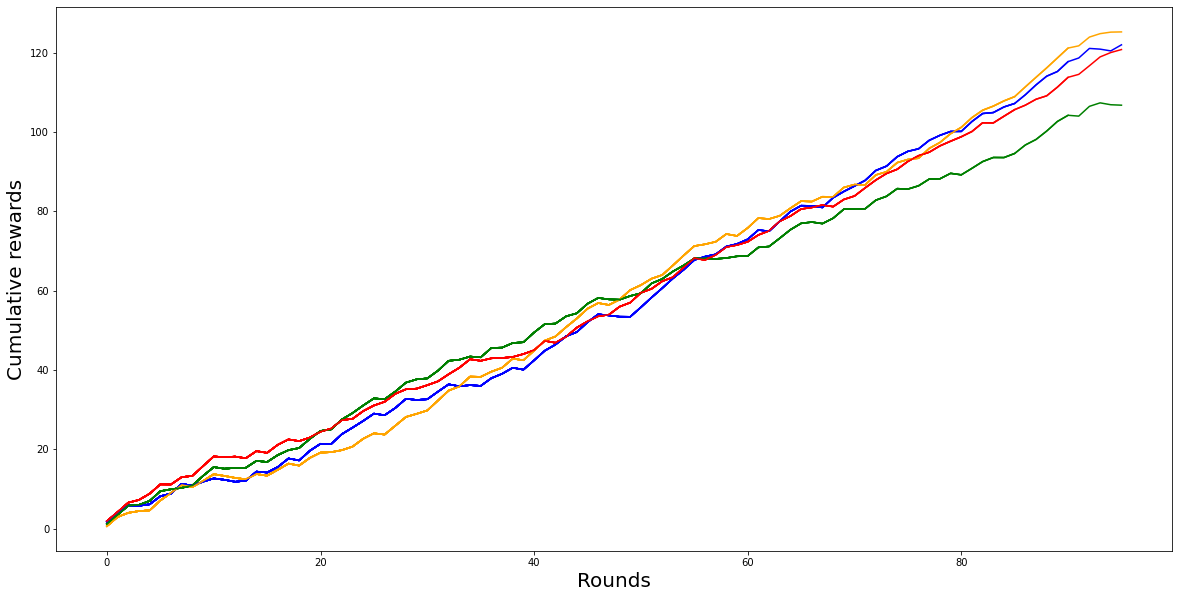

 98%|█████████▊| 98/100 [04:17<00:07,  3.54s/it]

IN BETWEEN********************************


100%|██████████| 100/100 [04:26<00:00,  2.67s/it]


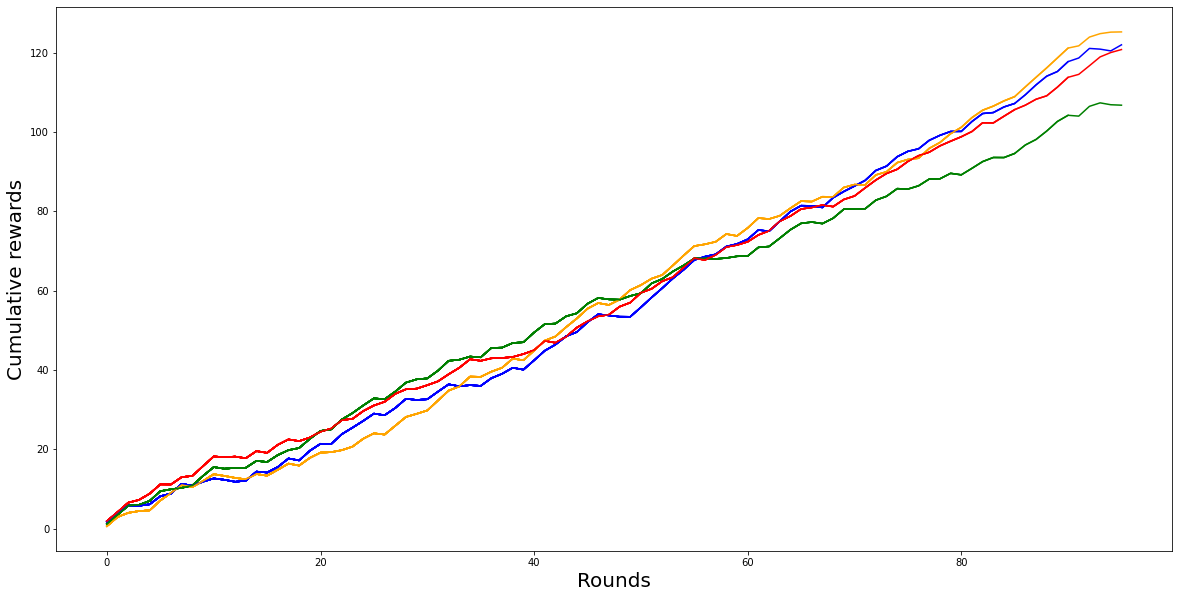

In [ ]:
np.random.seed(0)

# create an environment
environment = DummyEnvironment(actions, contexts, gen_f1, noise = 0.25)

# initialize CGP-UCB
agent_cbmp = CBMPUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                     gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                     inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cbme = CBMEUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                     gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                     inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cmp = CMPUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                   gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                   inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cme = CMEUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                   gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params2, r_dim=r_dim)


# rounds = 300
verbose = True
context_numbers = contexts.size
best_strategy_rewards = []
pbar = trange(rounds)
for i in pbar:
  # choose a random context.
  context_index = np.floor(np.random.rand()*context_numbers)
  # iterate learning algorithm for 1 round.
  agent_cbmp.learn(context_index, learn_freq = learn_freq)
  agent_cbme.learn(context_index, learn_freq = learn_freq)
  agent_cmp.learn(context_index, learn_freq = learn_freq)
  agent_cme.learn(context_index)
  
  # get best_strategy's reward for the current context.
  best_strategy_rewards.append(environment.get_best_reward_in_context(context_index))

  if i % 5 == 0:
    plot_regret_loop(agent = true_f(np.array(agent_cbmp.Y).squeeze(1)), 
                      agent2 = true_f(np.array(agent_cbme.Y).squeeze(1)), 
                      agent3 = true_f(np.array(agent_cmp.Y).squeeze(1)),
                      agent4 = true_f(np.array(agent_cme.Y).squeeze(1)))


pbar.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

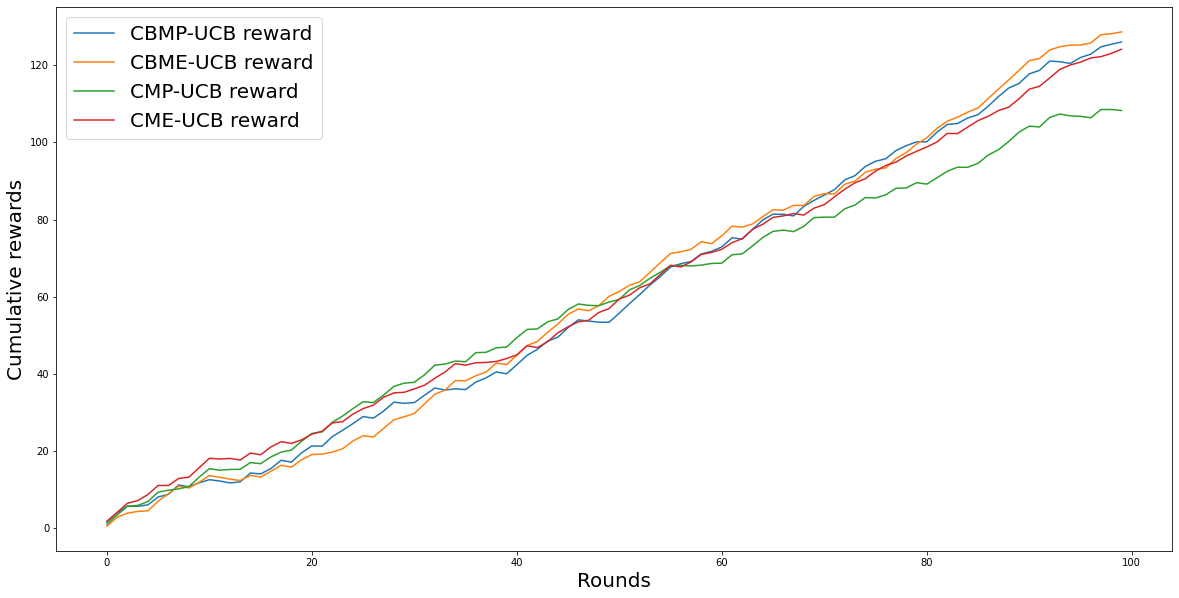

In [ ]:
cbmp_result = true_f(np.array(agent_cbmp.Y).squeeze(1))
cbme_result = true_f(np.array(agent_cbme.Y).squeeze(1))
cmp_result = true_f(np.array(agent_cmp.Y).squeeze(1))
cme_result = true_f(np.array(agent_cme.Y).squeeze(1))

plot_regret(agent = cbmp_result, 
            agent2 = cbme_result, 
            agent3 = cmp_result,
            agent4 = cme_result,
            file_name = "matched_experiment1.png")

In [ ]:
'''
with open(r'/content/drive/MyDrive/OxDissertation/case2/0.25/cbmp1', 'w') as fp:
    for item in list(cbmp_result):
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
with open(r'/content/drive/MyDrive/OxDissertation/case2/0.25/cbme1', 'w') as fp:
    for item in list(cbme_result):
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
with open(r'/content/drive/MyDrive/OxDissertation/case2/0.25/cmp1', 'w') as fp:
    for item in list(cmp_result):
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
with open(r'/content/drive/MyDrive/OxDissertation/case2/0.25/cme1', 'w') as fp:
    for item in list(cme_result):
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
'''

'\nwith open(r\'/content/drive/MyDrive/OxDissertation/case2/0.25/cbmp1\', \'w\') as fp:\n    for item in list(cbmp_result):\n        # write each item on a new line\n        fp.write("%s\n" % item)\n    print(\'Done\')\nwith open(r\'/content/drive/MyDrive/OxDissertation/case2/0.25/cbme1\', \'w\') as fp:\n    for item in list(cbme_result):\n        # write each item on a new line\n        fp.write("%s\n" % item)\n    print(\'Done\')\nwith open(r\'/content/drive/MyDrive/OxDissertation/case2/0.25/cmp1\', \'w\') as fp:\n    for item in list(cmp_result):\n        # write each item on a new line\n        fp.write("%s\n" % item)\n    print(\'Done\')\nwith open(r\'/content/drive/MyDrive/OxDissertation/case2/0.25/cme1\', \'w\') as fp:\n    for item in list(cme_result):\n        # write each item on a new line\n        fp.write("%s\n" % item)\n    print(\'Done\')\n'

# Experiment 2

In [ ]:
class DummyEnvironment(object):

  def __init__(self, actions, contexts, gen_f, noise = 0.02):
    self.input_mesh = np.array(np.meshgrid(actions, contexts))
    self.gen_f = gen_f
    self.noise = noise

  def sample(self, x):
    return np.array([np.sin(x[0] + x[1]), np.sin(x[0] - x[1])])

  def sample_noisy(self, x):
    return [self.sample(x) + np.random.normal(loc=0.0, scale=self.noise, size = x.shape)] #0.02

  def find_best_input_in_context(self, context_space, M = 1000):
    aux = np.zeros((M, context_space.shape[1]))
    for i in range(M):
        aux[i, :] = self.gen_f(np.array(self.sample_noisy(context_space)))
    #return np.argmax(np.mean(aux, 0))
    return np.max(np.mean(aux, 0))

  def get_best_reward_in_context(self, context_index):
    context_index = int(context_index)
    actions_context_pair = np.array(self.input_mesh[:,context_index,:])
    return self.find_best_input_in_context(actions_context_pair)

In [ ]:
np.random.seed(0)
# m = 0
paramsD2 = [-2, 2]
r_dim = 2

sample_typeD2 = "uniform"

def true_f(y):
  aux = np.zeros(y.shape[0])
  for i in range(y.shape[0]):
    aux[i] = 1.5*(np.tanh(5*np.pi*y[i, 0]) + np.cos(np.pi*y[i, 1])) + 1
  return aux
def true_f1(y):
  return 1.5*(np.tanh(5*np.pi*y[0, 0]) + np.cos(np.pi*y[0, 1])) + 1
def gen_f(y):
  return true_f(y) + np.random.normal(size = y.shape[0])
def gen_f1(y):
  return true_f1(y) + np.random.normal(size = (y.shape[0], 1))

y2, t = sample_D1(m, paramsD2, sample_typeD2, gen_f, random_state=1, verbose=False)

y2ten = torch.tensor(y2).float()
tten = torch.tensor(t).float().reshape(-1)

 # Learn param for GP
lr = 1e-1
epoch = 500
verbose = True
print('y2ten.shape:', y2ten.shape)
print('tten.shape:', tten.shape)
optim_eta, optim_y_scle, optim_noise, inner_model, inner_likelihood = train_GP(y2ten, tten, lr, epoch, fixed_y_lscale = None, verbose = False)
inner_model.eval()
inner_likelihood.eval()

params = {'optim_x_scle': .1, 
          'optim_y_scle': optim_y_scle,
          'optim_eta': optim_eta, 
          'optim_noise': optim_noise,
          'optim_lambda': 1.}

params2 = {'optim_x_scle': .1, 
          'optim_y_scle': .05,
          'optim_noise': 0.01,
          'optim_lambda': 1.,
          'cme_bound': cme_bound,
          'f_bound': f_bound,
          'sigma_in': 2,
          'sigma_out': 2}


# create a set of actions and contexts
actions = np.arange(-3, 3.25, 0.1)
contexts = np.arange(-3, 3.25, 0.1)

y2ten.shape: torch.Size([0, 2])
tten.shape: torch.Size([0])


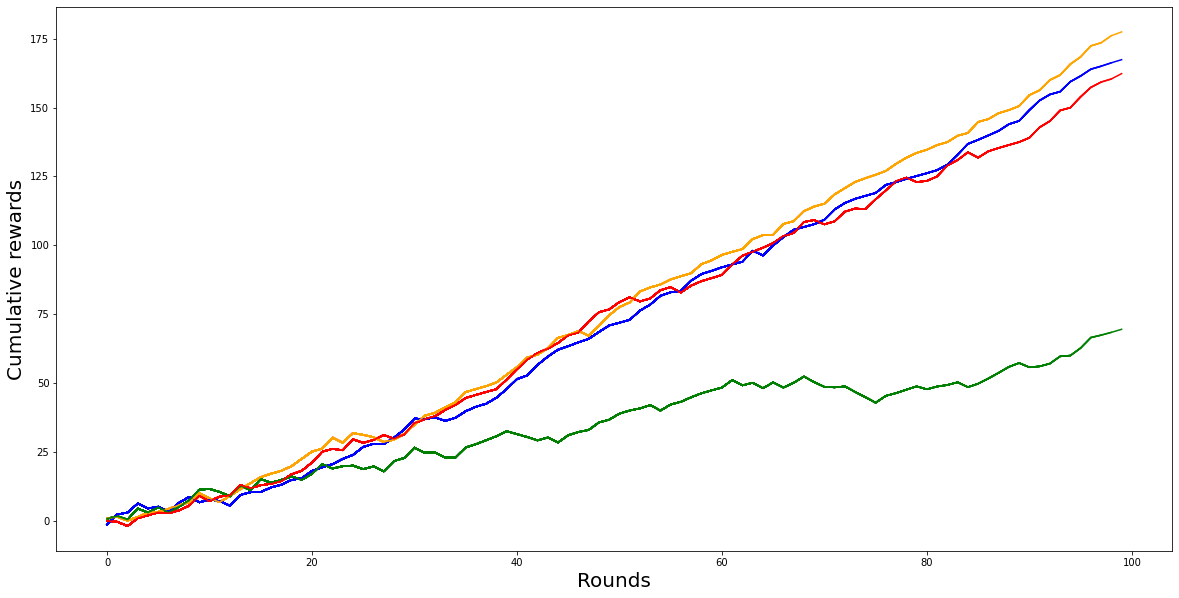

100%|██████████| 100/100 [04:55<00:00,  2.95s/it]


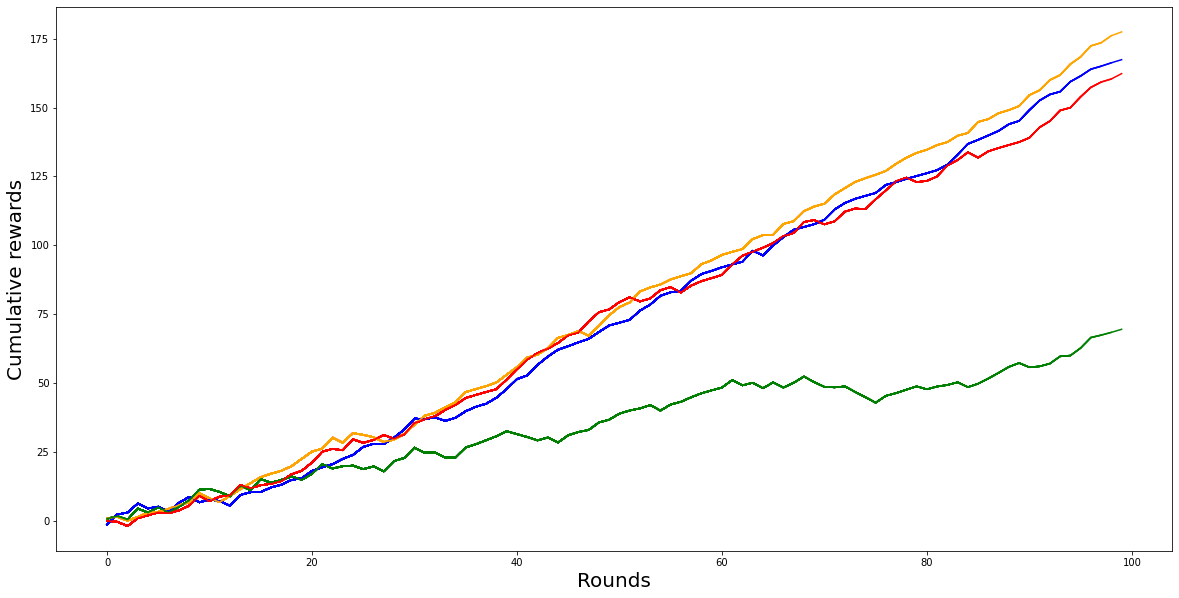

In [ ]:
np.random.seed(0)

# create an environment
environment = DummyEnvironment(actions, contexts, gen_f1, noise = 0.25)

# initialize CGP-UCB
agent_cbmp2 = CBMPUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                     gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                     inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cbme2 = CBMEUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                     gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                     inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cmp2 = CMPUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                   gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                   inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cme2 = CMEUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                   gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params2, r_dim=r_dim)


# rounds = 300
verbose = True
context_numbers = contexts.size
best_strategy_rewards = []
pbar = trange(rounds)
for i in pbar:
  # choose a random context.
  context_index = np.floor(np.random.rand()*context_numbers)
  # iterate learning algorithm for 1 round.
  agent_cbmp2.learn(context_index, learn_freq = learn_freq)
  agent_cbme2.learn(context_index, learn_freq = learn_freq)
  agent_cmp2.learn(context_index, learn_freq = learn_freq)
  agent_cme2.learn(context_index)
  # get best_strategy's reward for the current context.
  best_strategy_rewards.append(environment.get_best_reward_in_context(context_index))

  plot_regret_loop(agent = true_f(np.array(agent_cbmp2.Y).squeeze(1)), 
                    agent2 = true_f(np.array(agent_cbme2.Y).squeeze(1)), 
                    agent3 = true_f(np.array(agent_cmp2.Y).squeeze(1)),
                    agent4 = true_f(np.array(agent_cme2.Y).squeeze(1)))


pbar.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

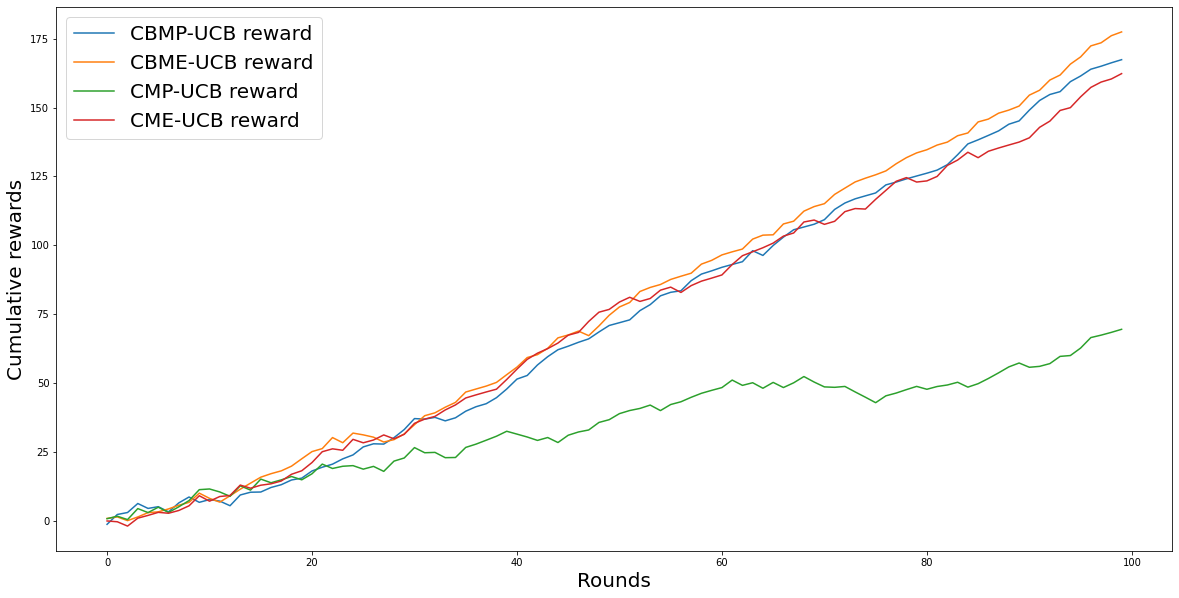

In [ ]:
cbmp_result2 = true_f(np.array(agent_cbmp2.Y).squeeze(1))
cbme_result2 = true_f(np.array(agent_cbme2.Y).squeeze(1))
cmp_result2 = true_f(np.array(agent_cmp2.Y).squeeze(1))
cme_result2 = true_f(np.array(agent_cme2.Y).squeeze(1))

plot_regret(agent = cbmp_result2, 
            agent2 = cbme_result2, 
            agent3 = cmp_result2,
            agent4 = cme_result2,
            file_name = "matched_experiment2.png")


# Experiment 3

In [ ]:
class DummyEnvironment1(object):

  def __init__(self, actions, contexts, gen_f, noise = 0.02):
    self.input_mesh = np.array(np.meshgrid(actions, contexts))
    self.gen_f = gen_f
    self.noise = noise

  def sample(self, x):
    return np.array([x[1]*np.sin(x[0]), x[0]*np.cos(x[1])])

  def sample_noisy(self, x):
    return [self.sample(x) + np.random.normal(loc=0.0, scale=self.noise, size = x.shape)] #0.02

  def find_best_input_in_context(self, context_space, M = 1000):
    aux = np.zeros((M, context_space.shape[1]))
    for i in range(M):
        aux[i, :] = self.gen_f(np.array(self.sample_noisy(context_space)))
    #return np.argmax(np.mean(aux, 0))
    return np.max(np.mean(aux, 0))

  def get_best_reward_in_context(self, context_index):
    context_index = int(context_index)
    actions_context_pair = np.array(self.input_mesh[:,context_index,:])
    return self.find_best_input_in_context(actions_context_pair)

In [ ]:
np.random.seed(0)
# m = 0
paramsD2 = [-2, 2]
r_dim = 2

sample_typeD2 = "uniform"

def true_f(y):
  aux = np.zeros(y.shape[0])
  for i in range(y.shape[0]):
    aux[i] = 1.5*np.cos(np.pi*y[i, 0] + np.pi*y[i, 1]) + 1
  return aux
def true_f1(y):
  return 1.5*np.cos(np.pi*y[0, 0] + np.pi*y[0, 1]) + 1
def gen_f(y):
  return true_f(y) + 0.05*np.random.normal(size = y.shape[0])
def gen_f1(y):
  return true_f1(y) + 0.05*np.random.normal(size = (y.shape[0], 1))

y2, t = sample_D1(m, paramsD2, sample_typeD2, gen_f, random_state=1, verbose=False)
y2ten = torch.tensor(y2).float()
tten = torch.tensor(t).float().reshape(-1)

 # Learn param for GP
lr = 1e-1
epoch = 500
verbose = True
print('y2ten.shape:', y2ten.shape)
print('tten.shape:', tten.shape)
optim_eta, optim_y_scle, optim_noise, inner_model, inner_likelihood = train_GP(y2ten, tten, lr, epoch, fixed_y_lscale = None, verbose = False)
inner_model.eval()
inner_likelihood.eval()

params = {'optim_x_scle': 1., 
          'optim_y_scle': optim_y_scle,
          'optim_eta': optim_eta, 
          'optim_noise': optim_noise,
          'optim_lambda': 1.}

params2 = {'optim_x_scle': .1, 
          'optim_y_scle': .05,
          'optim_noise': 0.01,
          'optim_lambda': 1.,
          'cme_bound': cme_bound,
          'f_bound': f_bound,
          'sigma_in': 2,
          'sigma_out': 2}


# create a set of actions and contexts
actions = np.arange(-3, 3, 0.1)
contexts = np.arange(-3, 3, 0.1)

y2ten.shape: torch.Size([0, 2])
tten.shape: torch.Size([0])


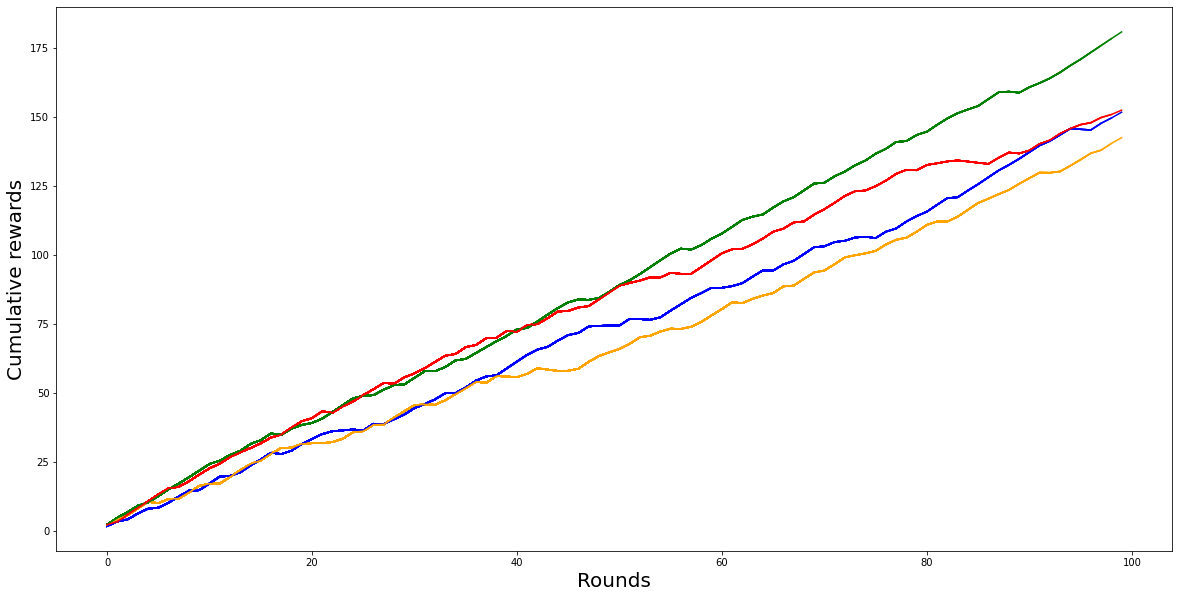

100%|██████████| 100/100 [03:57<00:00,  2.38s/it]


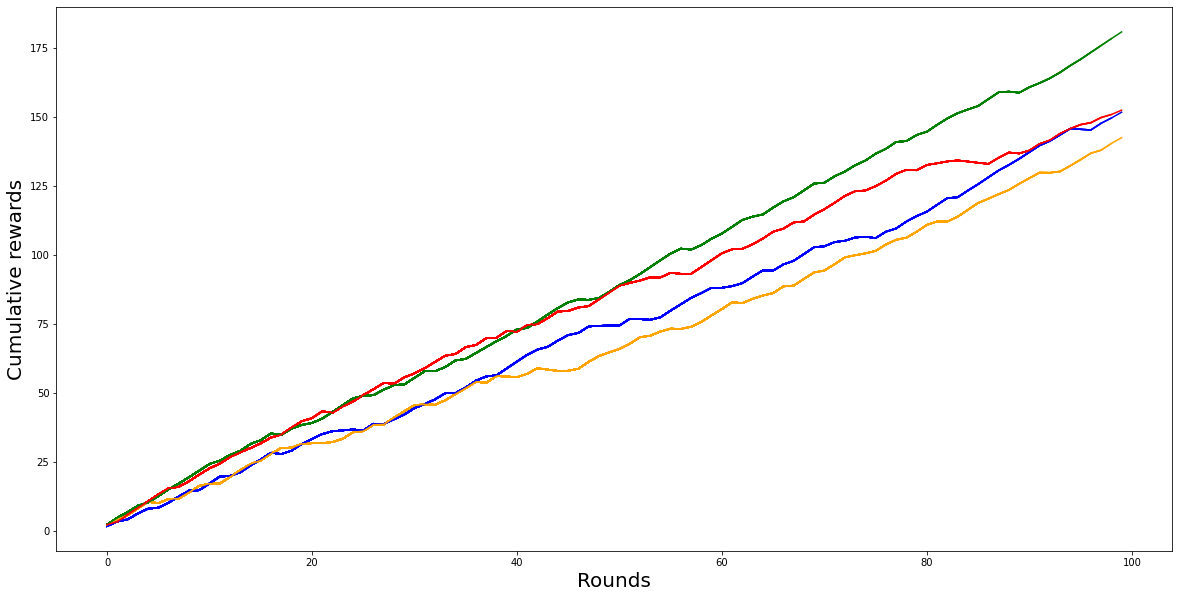

In [ ]:
np.random.seed(0)

# create an environment
environment = DummyEnvironment(actions, contexts, gen_f1, noise = 0.25)

# initialize CGP-UCB
agent_cbmp3 = CBMPUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                     gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                     inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cbme3 = CBMEUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                     gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                     inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cmp3 = CMPUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                   gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                   inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cme3 = CMEUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                   gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params2, r_dim=r_dim)

# rounds = 300
verbose = True
context_numbers = contexts.size
best_strategy_rewards = []
pbar = trange(rounds)
for i in pbar:
  # choose a random context.
  context_index = np.floor(np.random.rand()*context_numbers)
  # iterate learning algorithm for 1 round.
  agent_cbmp3.learn(context_index, learn_freq = learn_freq)
  agent_cbme3.learn(context_index, learn_freq = learn_freq)
  agent_cmp3.learn(context_index, learn_freq = learn_freq)
  agent_cme3.learn(context_index)
  # get best_strategy's reward for the current context.
  best_strategy_rewards.append(environment.get_best_reward_in_context(context_index))

  plot_regret_loop(agent = true_f(np.array(agent_cbmp3.Y).squeeze(1)), 
                    agent2 = true_f(np.array(agent_cbme3.Y).squeeze(1)), 
                    agent3 = true_f(np.array(agent_cmp3.Y).squeeze(1)),
                    agent4 = true_f(np.array(agent_cme3.Y).squeeze(1)))


pbar.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

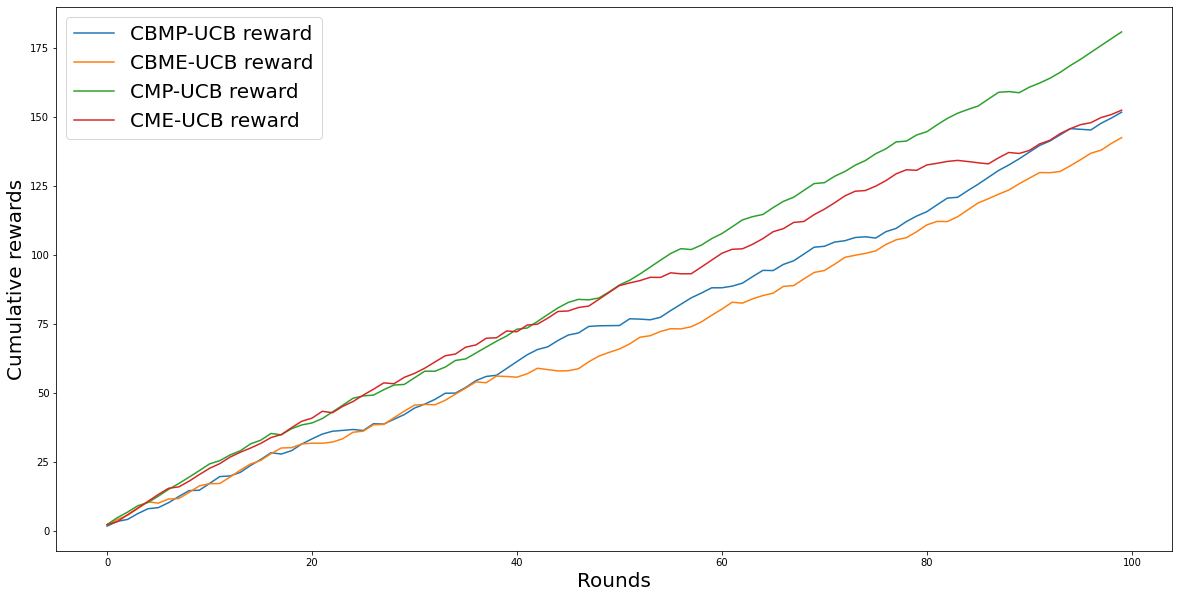

In [ ]:
cbmp_result3 = true_f(np.array(agent_cbmp3.Y).squeeze(1))
cbme_result3 = true_f(np.array(agent_cbme3.Y).squeeze(1))
cmp_result3 = true_f(np.array(agent_cmp3.Y).squeeze(1))
cme_result3 = true_f(np.array(agent_cme3.Y).squeeze(1))

plot_regret(agent = cbmp_result3, 
            agent2 = cbme_result3, 
            agent3 = cmp_result3,
            agent4 = cme_result3,
            file_name = "matched_experiment3.png")

# Experiment 4

In [ ]:
class DummyEnvironment(object):

  def __init__(self, actions, contexts, gen_f, noise = 0.02):
    self.input_mesh = np.array(np.meshgrid(actions, contexts))
    self.gen_f = gen_f
    self.noise = noise

  def sample(self, x):
    return np.array([np.sin(x[0]), np.cos(x[1])])

  def sample_noisy(self, x):
    return [self.sample(x) + np.random.normal(loc=0.0, scale=self.noise, size = x.shape)] #0.02

  def find_best_input_in_context(self, context_space, M = 1000):
    aux = np.zeros((M, context_space.shape[1]))
    for i in range(M):
        aux[i, :] = self.gen_f(np.array(self.sample_noisy(context_space)))
    #return np.argmax(np.mean(aux, 0))
    return np.max(np.mean(aux, 0))

  def get_best_reward_in_context(self, context_index):
    context_index = int(context_index)
    actions_context_pair = np.array(self.input_mesh[:,context_index,:])
    return self.find_best_input_in_context(actions_context_pair)

In [ ]:
np.random.seed(0)
# m = 0
paramsD2 = [-2, 2]

sample_typeD2 = "uniform"

def true_f(y):
  aux = np.zeros(y.shape[0])
  for i in range(y.shape[0]):
    aux[i] = 1.5*(np.sin(np.pi*y[i, 0]) + np.sin(np.pi*y[i, 1])) + 1
  return aux
def true_f1(y):
  return 1.5*(np.sin(np.pi*y[0,0]) + np.sin(np.pi*y[0,1])) + 1
def gen_f(y):
  return true_f(y) + np.random.normal(size = y.shape[0])
def gen_f1(y):
  return true_f1(y) + np.random.normal(size = (y.shape[0], 1))

y2, t = sample_D1(m, paramsD2, sample_typeD2, gen_f, random_state=1, verbose=False)

y2ten = torch.tensor(y2).float()
tten = torch.tensor(t).float().reshape(-1)

 # Learn param for GP
lr = 1e-1
epoch = 500
verbose = True
print('y2ten.shape:', y2ten.shape)
print('tten.shape:', tten.shape)
optim_eta, optim_y_scle, optim_noise, inner_model, inner_likelihood = train_GP(y2ten, tten, lr, epoch, fixed_y_lscale = None, verbose = False)
inner_model.eval()
inner_likelihood.eval()

params = {'optim_x_scle': .1, 
          'optim_y_scle': optim_y_scle,
          'optim_eta': optim_eta, 
          'optim_noise': optim_noise,
          'optim_lambda': 1.}

params2 = {'optim_x_scle': .1, 
          'optim_y_scle': .05,
          'optim_noise': 0.01,
          'optim_lambda': 1.,
          'cme_bound': cme_bound,
          'f_bound': f_bound,
          'sigma_in': 2,
          'sigma_out': 2}


# create a set of actions and contexts
actions = np.arange(-3, 3.25, 0.1)
contexts = np.arange(-3, 3.25, 0.1)

y2ten.shape: torch.Size([0, 2])
tten.shape: torch.Size([0])


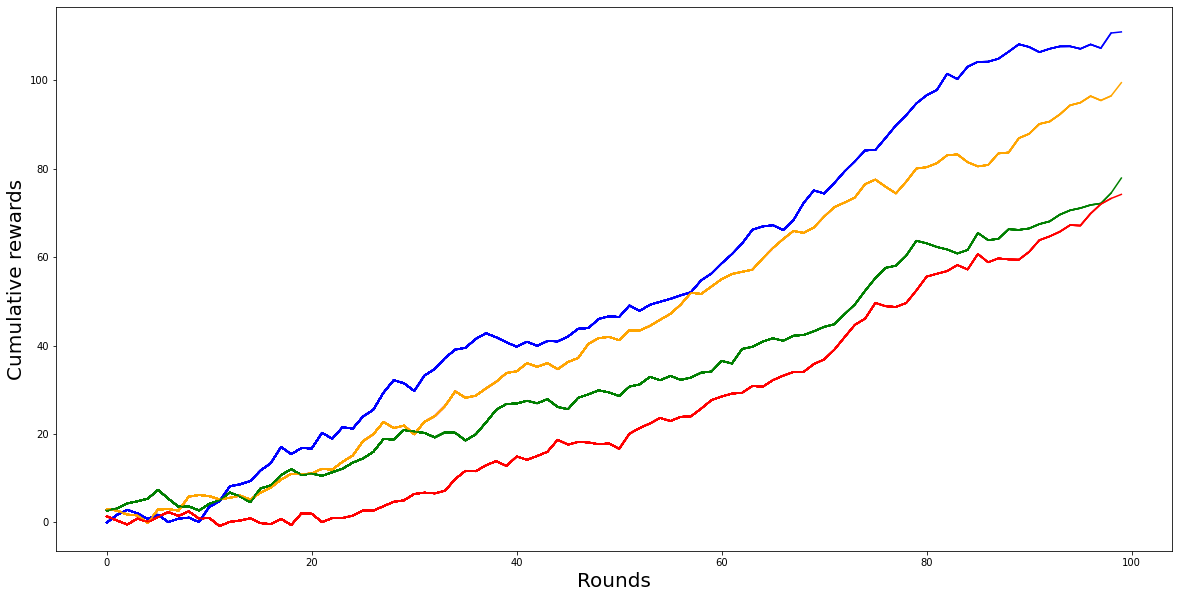

100%|██████████| 100/100 [05:00<00:00,  3.00s/it]


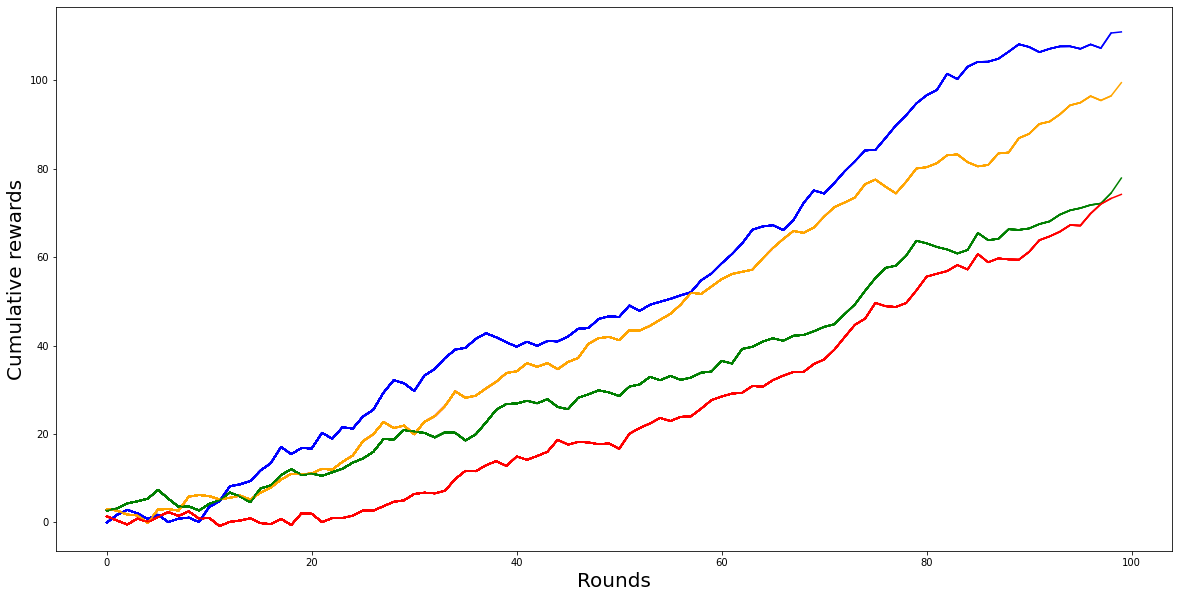

In [ ]:
np.random.seed(0)

# create an environment
environment = DummyEnvironment(actions, contexts, gen_f1, noise = 0.25)

# initialize CGP-UCB
agent_cbmp4 = CBMPUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                     gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                     inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cbme4 = CBMEUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                     gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                     inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cmp4 = CMPUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                   gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params, 
                   inner_model=inner_model, inner_likelihood=inner_likelihood, r_dim=r_dim)
agent_cme4 = CMEUCB(actions=actions, contexts=contexts, sample_from_environment=environment.sample_noisy, 
                   gen_f=environment.gen_f, y2ten=y2ten, tten=tten, params=params2, r_dim=r_dim)

# rounds = 300
verbose = True
context_numbers = contexts.size
best_strategy_rewards = []
pbar = trange(rounds)
for i in pbar:
  # choose a random context.
  context_index = np.floor(np.random.rand()*context_numbers)
  # iterate learning algorithm for 1 round.
  agent_cbmp4.learn(context_index, learn_freq = learn_freq)
  agent_cbme4.learn(context_index, learn_freq = learn_freq)
  agent_cmp4.learn(context_index, learn_freq = learn_freq)
  agent_cme4.learn(context_index)
  # get best_strategy's reward for the current context.
  best_strategy_rewards.append(environment.get_best_reward_in_context(context_index))

  plot_regret_loop(agent = true_f(np.array(agent_cbmp4.Y).squeeze(1)), 
                    agent2 = true_f(np.array(agent_cbme4.Y).squeeze(1)), 
                    agent3 = true_f(np.array(agent_cmp4.Y).squeeze(1)),
                    agent4 = true_f(np.array(agent_cme4.Y).squeeze(1)))


pbar.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

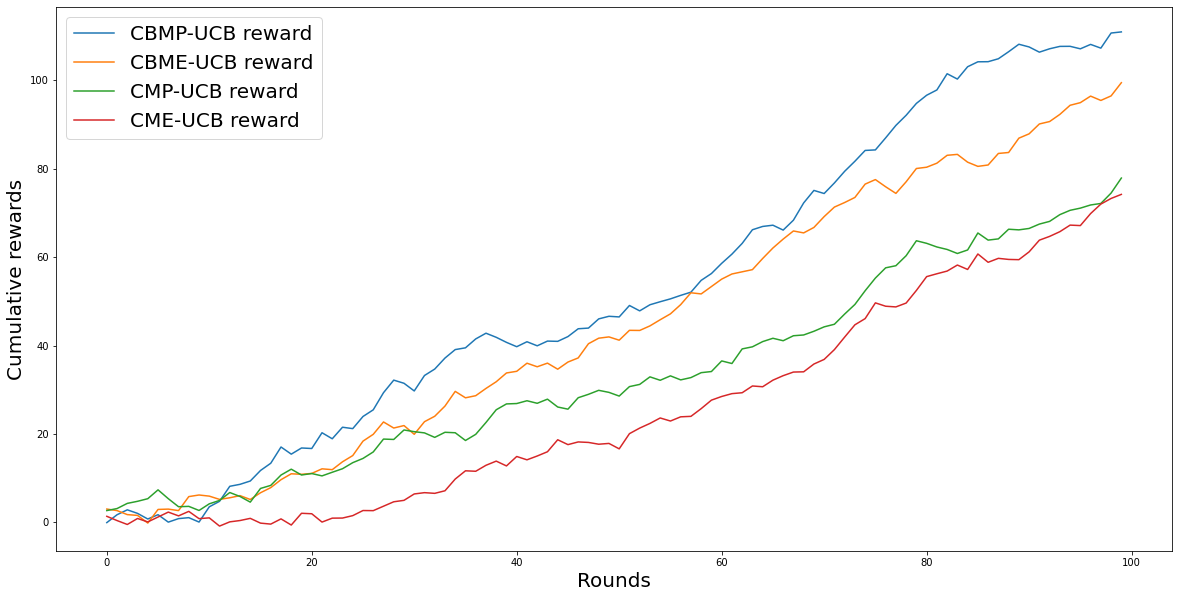

In [ ]:
cbmp_result4 = true_f(np.array(agent_cbmp4.Y).squeeze(1))
cbme_result4 = true_f(np.array(agent_cbme4.Y).squeeze(1))
cmp_result4 = true_f(np.array(agent_cmp4.Y).squeeze(1))
cme_result4 = true_f(np.array(agent_cme4.Y).squeeze(1))

plot_regret(agent = cbmp_result4, 
            agent2 = cbme_result4, 
            agent3 = cmp_result4,
            agent4 = cme_result4,
            file_name = "matched_experiment4.png")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

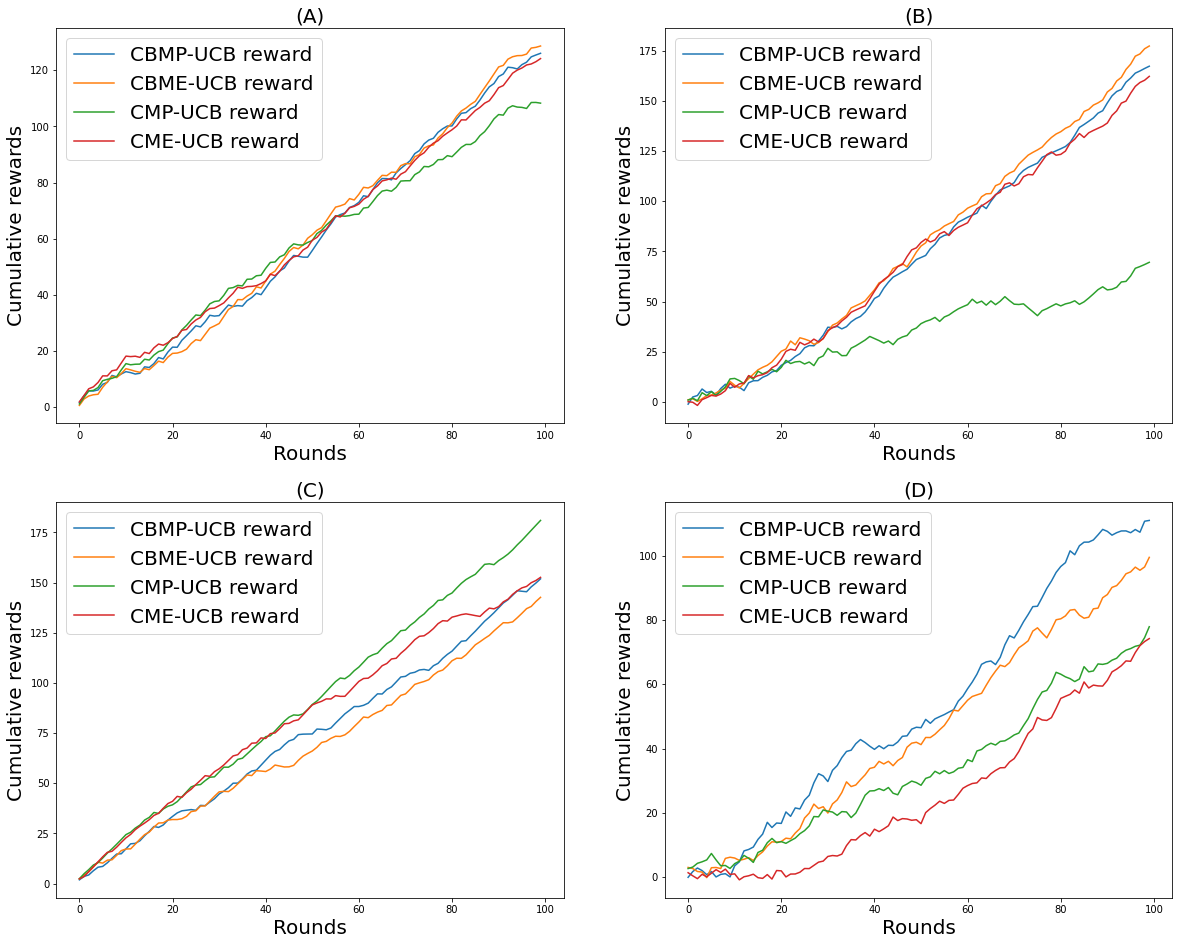

In [ ]:
plt.rcParams["figure.figsize"] = (20,16)
fig, axs = plt.subplots(2, 2)
fontsize = 20
legendsize = 20

cum_agent = np.cumsum(np.array(cbmp_result))
axs[0, 0].plot(cum_agent, label="CBMP-UCB reward")
cum_agent2 = np.cumsum(np.array(cbme_result))
axs[0, 0].plot(cum_agent2, label="CBME-UCB reward")
cum_agent3 = np.cumsum(np.array(cmp_result))
axs[0, 0].plot(cum_agent3, label="CMP-UCB reward")
cum_agent4 = np.cumsum(np.array(cme_result))
axs[0, 0].plot(cum_agent4, label="CME-UCB reward")
title = '(A)'
axs[0, 0].set_title(title, fontsize = fontsize)

cum_agent = np.cumsum(np.array(cbmp_result2))
axs[0, 1].plot(cum_agent, label="CBMP-UCB reward")
cum_agent2 = np.cumsum(np.array(cbme_result2))
axs[0, 1].plot(cum_agent2, label="CBME-UCB reward")
cum_agent3 = np.cumsum(np.array(cmp_result2))
axs[0, 1].plot(cum_agent3, label="CMP-UCB reward")
cum_agent4 = np.cumsum(np.array(cme_result2))
axs[0, 1].plot(cum_agent4, label="CME-UCB reward")
title = '(B)'
axs[0, 1].set_title(title, fontsize = fontsize)

cum_agent = np.cumsum(np.array(cbmp_result3))
axs[1, 0].plot(cum_agent, label="CBMP-UCB reward")
cum_agent2 = np.cumsum(np.array(cbme_result3))
axs[1, 0].plot(cum_agent2, label="CBME-UCB reward")
cum_agent3 = np.cumsum(np.array(cmp_result3))
axs[1, 0].plot(cum_agent3, label="CMP-UCB reward")
cum_agent4 = np.cumsum(np.array(cme_result3))
axs[1, 0].plot(cum_agent4, label="CME-UCB reward")
title = '(C)'
axs[1, 0].set_title(title, fontsize = fontsize)

cum_agent = np.cumsum(np.array(cbmp_result4))
axs[1, 1].plot(cum_agent, label="CBMP-UCB reward")
cum_agent2 = np.cumsum(np.array(cbme_result4))
axs[1, 1].plot(cum_agent2, label="CBME-UCB reward")
cum_agent3 = np.cumsum(np.array(cmp_result4))
axs[1, 1].plot(cum_agent3, label="CMP-UCB reward")
cum_agent4 = np.cumsum(np.array(cme_result4))
axs[1, 1].plot(cum_agent4, label="CME-UCB reward")
title = '(D)'
axs[1, 1].set_title(title, fontsize = fontsize)

for ax in axs.flat:
    ax.set_xlabel('Rounds', fontsize=20)
    ax.set_ylabel('Cumulative rewards', fontsize = 20)
    ax.legend(prop={'size': 20})

plt.savefig("matched_four_experiments.png", bbox_inches='tight')
files.download("matched_four_experiments.png") 
